In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm import tqdm
from glob import glob
import os, sys
import numpy as np
from configs import *
from utils import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from dataset import *
import torch.optim as optim
torch.manual_seed(0)
np.random.seed(0)

In [3]:
ESIZE = 64
EPS = 120
BSIZE = 32
HSIZE = 64
LAG = 12
SROUTE = SAMPLE_ROUTES[0]
SIND = 30
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [4]:
dset = SingleStop(SROUTE, SIND, 'train', BSIZE, lag=LAG)#.generator()
evalset = SingleStop(SROUTE, SIND, 'test', BSIZE, lag=LAG)#.generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.21s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
 [*] Subset in Stop-30: 6079
Locals dataset: test
 [*] Loaded routes: 1 (0.24s)
 [*] Has trainable inds: 262262
 [*] Subset test: 50156
 [*] Subset in Stop-30: 1549


In [5]:
class Node:
    def __init__(self, value):
        self._v = value.clone().to(device) # label
        self.v = value.to(device)
        self.h = torch.zeros(BSIZE, HSIZE).to(device)
        self.ns = [] # neighbors
    
    def show(self):
        pnt = self
        while len(pnt.ns):
            print(pnt.v.size(), end=' ')
            pnt = pnt.ns[0]
        print()
        
    def ln(self):
        l = 0
        pnt = self
        while len(pnt.ns):
            pnt = pnt.ns[0]
            l += 1
        return l
        
def routeToGraph(batch):
    at_time = [] # t-h ... t
    for time in torch.split(batch, 1, dim=1):
        root, pnt = None, None
        for stop in torch.split(time.squeeze(1), 1, dim=1):
            if root is None:
                root = Node(stop)
                pnt = root
            else:
                nd = Node(stop)
                pnt.ns.append(nd)
                pnt = nd
        at_time.append(root)
    return at_time

def inst_tree(struct, nodes):
    ls = []
    params = []
    for ent in nodes:
        inst = struct(ent) #.to(device)
        params += list(inst.parameters())
        inst.device = device
        ns, nparams = inst_tree(struct, ent.ns)
        params += nparams
        kobj = dict(
            op=inst,
            ns=ns
        )
        ls.append(kobj)
    return ls, params

In [6]:
kernels = None
upops = None

In [7]:
criterion = nn.MSELoss().to(device)
kopt, uopt, sch = None, None, None
LR = 0.001

In [8]:
from models.Kernel import Kernel, Update

def zip_op(t1, t2, op):
    ls = [(t1, t2)]
    while len(ls):
        n1, n2 = ls[0]
        ls = ls[1:]
        op(n1, n2)
        for c1, c2 in zip(n1['ns'], n2.ns):
            ls.append((c1, c2))

def message(kernels, graph_t):
    zip_op(kernels, graph_t, op=lambda kern, node: kern['op'](node))
    
def update(kernels, graph_t):
    zip_op(upops, graph_t, op=lambda up, node: up['op'](node))
    
def gather_predictions(_node, node):
    # end nodes do not hold convolved results, so they are ignored
    ls = [(_node._v, node.v)] if len(node.ns) else []
    for _nb, nb in zip(_node.ns, node.ns):
        ls += gather_predictions(_nb, nb)
    return ls

losses = []
for ii in range(0, len(dset) - BSIZE, BSIZE):
    batch = np.array([dset[ii+jj] for jj in range(BSIZE)])
    # batch x time x seq
    batch = torch.Tensor(batch)
    batch = routeToGraph(batch)

    states = batch[0] # will be used to hold iterated values
    if kernels is None:
        (kernels,), params = inst_tree(
            lambda node: Kernel(insize=1 + len(node.ns), hsize=HSIZE).to(device), 
            [states])
        kopt = optim.SGD(params, lr=LR)
        print('Params: %d' % len(params))
        (upops,), params = inst_tree(
            lambda _: Update(hsize=HSIZE).to(device), 
            [states])
        uopt = optim.SGD(params, lr=LR)

    # initial iteration
    _ = message(kernels, states)
    _ = update(upops, states)

    def fit(_ys, ys, retain=True):
        kopt.zero_grad()
        uopt.zero_grad()
        loss = criterion(ys, _ys)
        
        loss.backward(retain_graph=retain)
        kopt.step()
        uopt.step()
        return loss
    
    for ti, graph_t in enumerate(batch[1:]):
        # compute loss
        _ys, ys = zip(*gather_predictions(graph_t, states))
        _ys, ys = torch.cat(_ys, dim=1), torch.cat(ys, dim=1)
        
        loss = fit(_ys, ys, True)
#         print(loss.item(), _ys.size())
        
        # iterate
        _ = message(kernels, states)
        _ = update(upops, states)
        
        sys.stdout.write('[%d:%d - %d:%d] L%.2f    \r' % (
            ii//BSIZE, len(dset)//BSIZE, ti+2, len(batch),
            loss.item()))
        losses.append(loss.item())
    fit(_ys, ys, False) # don't forget to fit the last iteration
    
    sys.stdout.flush()
    # TODO: apply loss to all newvals
#     break

Params: 114


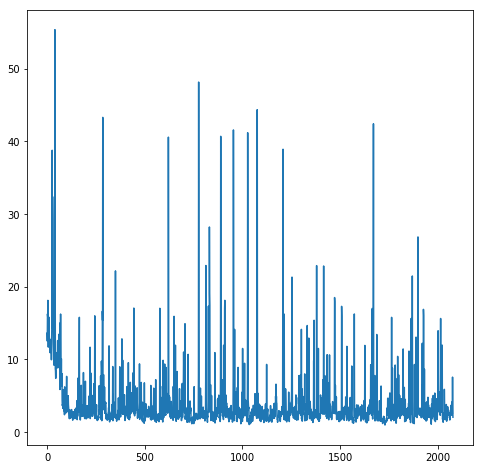

In [11]:
plt.figure(figsize=(8, 8))
plt.plot(losses)
plt.show(); plt.close()

In [9]:
_ys, ys = zip(*gather_predictions(graph_t, states))
_ys, ys = torch.cat(_ys, dim=1), torch.cat(ys, dim=1)

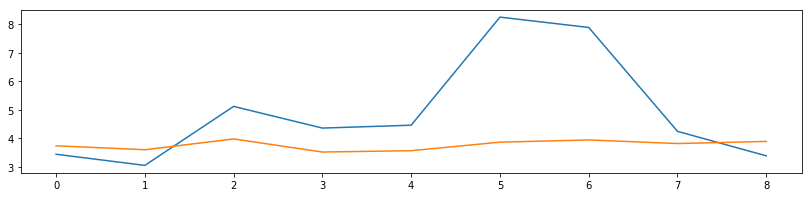

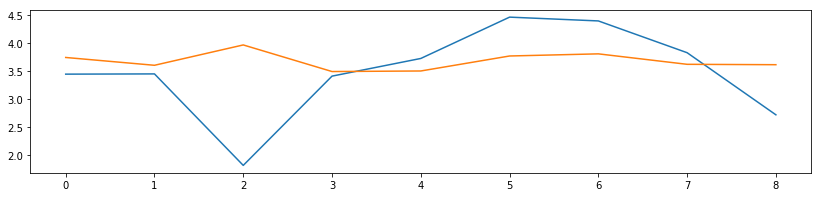

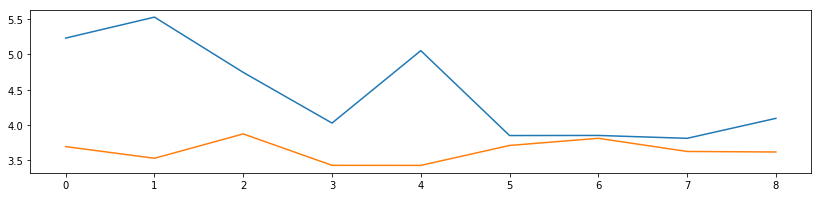

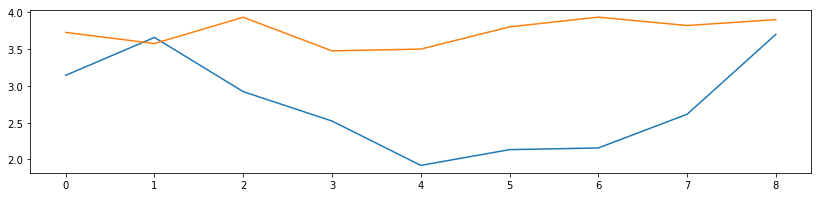

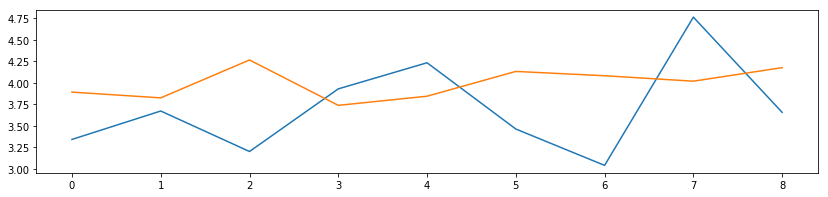

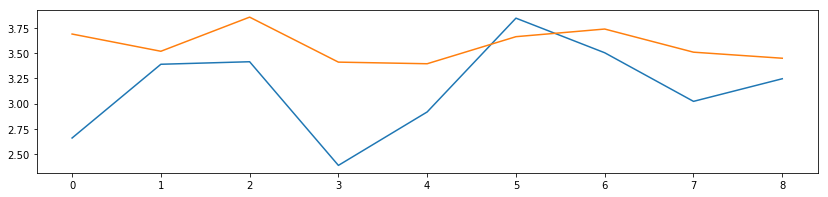

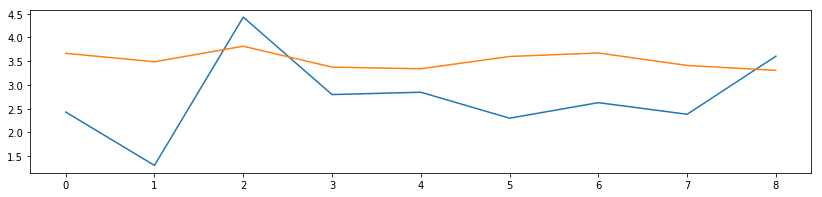

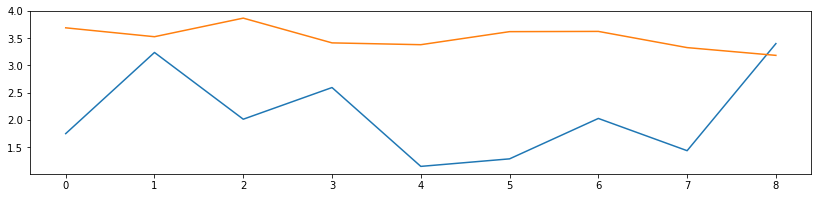

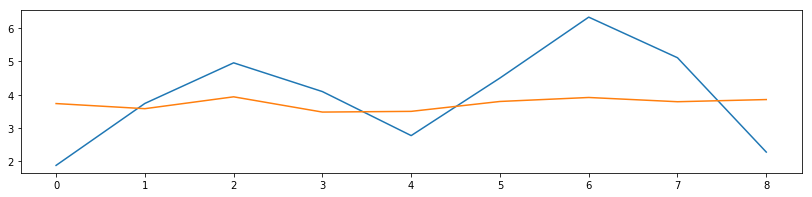

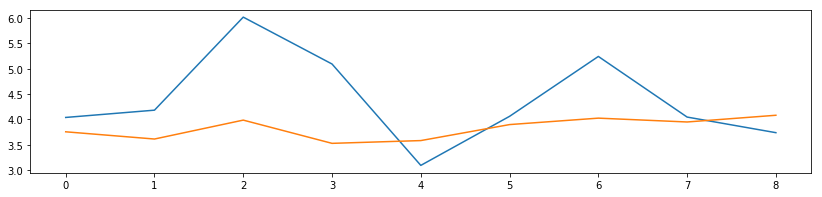

In [10]:
for ii in range(10):
    plt.figure(figsize=(14, 3))
    plt.plot(tonpy(_ys)[ii])
    plt.plot(tonpy(ys)[ii])
    plt.show(); plt.close()